In [64]:
import os
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import ast
import numpy as np
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
print(pipeline('sentiment-analysis')('we love you'))
print(pipeline('sentiment-analysis')('we hate you'))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998704195022583}]
[{'label': 'NEGATIVE', 'score': 0.9988259673118591}]


In [3]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [4]:
encoded_text = tokenizer('very good movie!', return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0018993656, 'roberta_neu': 0.013890146, 'roberta_pos': 0.9842106}


In [5]:
def polarity_scores_roberta(example):
    try:
        encoded_text = tokenizer(example, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        scores_dict = {
            'roberta_neg' : scores[0],
            'roberta_neu' : scores[1],
            'roberta_pos' : scores[2]
        }
    except:
        scores_dict = {
            'roberta_neg' : 0,
            'roberta_neu' : 0,
            'roberta_pos' : 0
        }
    return scores_dict

In [40]:
def read_return_file(folder_path):
    files_path = os.listdir(folder_path)
    files_path.sort()
    data_path_daily = ['{}{}'.format(folder_path,file) for file in files_path]
    data_path_daily = pd.DataFrame(data_path_daily,columns=['File Path'])
    data_path_daily['File Name'] = files_path
    return data_path_daily

In [7]:
for i,file in tqdm(enumerate(read_return_file('Datasets/Processed Tweet/'))):
    try:
        data = pd.read_csv(file,engine='python',index_col=0)
        data['sent_score']= data['clean_tweet'].astype('str').progress_apply(polarity_scores_roberta)
        data.to_csv('{}'.format(file))
    except:
        print(i)
        print(file)
        continue

100%|██████████| 20406/20406 [33:52<00:00, 10.04it/s]
5it [2:44:03, 1968.65s/it]


In [27]:
for i,file in tqdm(enumerate(read_return_file('Datasets/Processed Tweet/'))):
    data = pd.read_csv(file,engine='python',index_col=0)
    if 'POS' not in data.columns:
        try:
            data['sent_score'] = data['sent_score'].apply(lambda x: ast.literal_eval(x))
            data['POS'] = data['sent_score'].apply(lambda x: x['roberta_pos'])
            data['NEU'] = data['sent_score'].apply(lambda x: x['roberta_neu'])
            data['NEG'] = data['sent_score'].apply(lambda x: x['roberta_neg'])
            data.to_csv('{}'.format(file))
        except:
            print(i)
            print(file)
            continue
    else:
        continue

44it [00:16,  2.71it/s]


In [49]:
col_names = ['following','followers','totaltweets','retweetcount','created_at', 'clean_tweet','POS','NEU','NEG']
for i,file in read_return_file('Datasets/Processed Tweet/').iterrows():
    data = pd.read_csv(file['File Path'],engine='python',index_col=0)
    data = data[col_names]
    data['created_at'] = pd.to_datetime(data['created_at'])
    data.to_csv('Datasets/Reduced Tweet Data/{}'.format(file['File Name']))


In [132]:
sentiment_scores = pd.DataFrame(columns=['POS','NEU','NEG'])
for i, file in read_return_file('Datasets/Reduced Tweet Data/').iterrows():
    data = pd.read_csv(file['File Path'],engine='python',index_col=0)
    print(data['created_at'][0])
    data['created_at'] = pd.to_datetime(data['created_at'])
    #daily_score = pd.DataFrame(data.groupby([data['created_at'].dt.hour])[['POS','NEU','NEG']].mean().mean())
    daily_score = pd.DataFrame(data[['POS','NEU','NEG']].mean())
    daily_score = daily_score.transpose()
    sentiment_scores = pd.concat([sentiment_scores,daily_score],axis=0,ignore_index=True)
    

2022-06-01 01:36:59+00:00
2022-06-02 00:01:59+00:00
2022-06-03 00:01:59+00:00
2022-06-04 00:01:59+00:00
2022-06-05 00:01:59+00:00
2022-06-06 00:01:59+00:00
2022-06-07 00:01:59+00:00
2022-06-08 00:01:59+00:00
2022-06-09 00:01:59+00:00
2022-06-10 00:01:59+00:00
2022-06-11 00:01:58+00:00
2022-06-12 00:01:59+00:00
2022-06-13 00:01:59+00:00
2022-06-14 00:01:59+00:00
2022-06-15 00:01:58+00:00
2022-06-16 00:01:59+00:00
2022-06-17 00:01:58+00:00
2022-06-18 00:01:59+00:00
2022-06-19 00:01:59+00:00
2022-06-20 00:01:59+00:00
2022-06-21 00:01:57+00:00
2022-06-22 00:01:59+00:00
2022-06-23 00:01:59+00:00
2022-06-24 00:01:59+00:00
2022-06-25 00:01:59+00:00
2022-06-26 00:01:59+00:00
2022-06-27 00:01:59+00:00
2022-06-28 00:01:59+00:00
2022-06-29 00:01:59+00:00
2022-06-30 00:01:59+00:00
2022-07-01 00:01:59+00:00
2022-07-01 00:01:59+00:00
2022-07-02 00:01:59+00:00
2022-07-03 00:01:59+00:00
2022-07-04 00:01:59+00:00
2022-07-05 00:01:59+00:00
2022-07-06 00:01:59+00:00
2022-07-07 00:01:59+00:00
2022-07-08 0

In [133]:
sentiment_scores

,POS,NEU,NEG
0,0.233312,0.639577,0.127111
1,0.229337,0.646701,0.123963
2,0.223581,0.655623,0.120796
3,0.235092,0.647630,0.117278
4,0.246482,0.641229,0.112289
5,0.232788,0.655388,0.111823
6,0.227116,0.655640,0.117244
7,0.239057,0.635180,0.125762
8,0.249787,0.639355,0.110858
9,0.248058,0.639744,0.112197


In [125]:
import matplotlib.pyplot as plt
sentiment_scores

,POS,NEU,NEG,POS+NEG,TEST
0,0.232025,0.641520,0.126455,0.358480,1.000000
1,0.229272,0.646742,0.123986,0.353258,1.000000
2,0.223593,0.655609,0.120799,0.344391,1.000000
3,0.235024,0.647712,0.117263,0.352288,1.000000
4,0.246662,0.641110,0.112228,0.358890,1.000000
5,0.232815,0.655371,0.111813,0.344629,1.000000
6,0.227161,0.655577,0.117262,0.344423,1.000000
7,0.239100,0.635141,0.125759,0.364859,1.000000
8,0.249738,0.639374,0.110888,0.360626,1.000000
9,0.248034,0.639779,0.112187,0.360221,1.000000


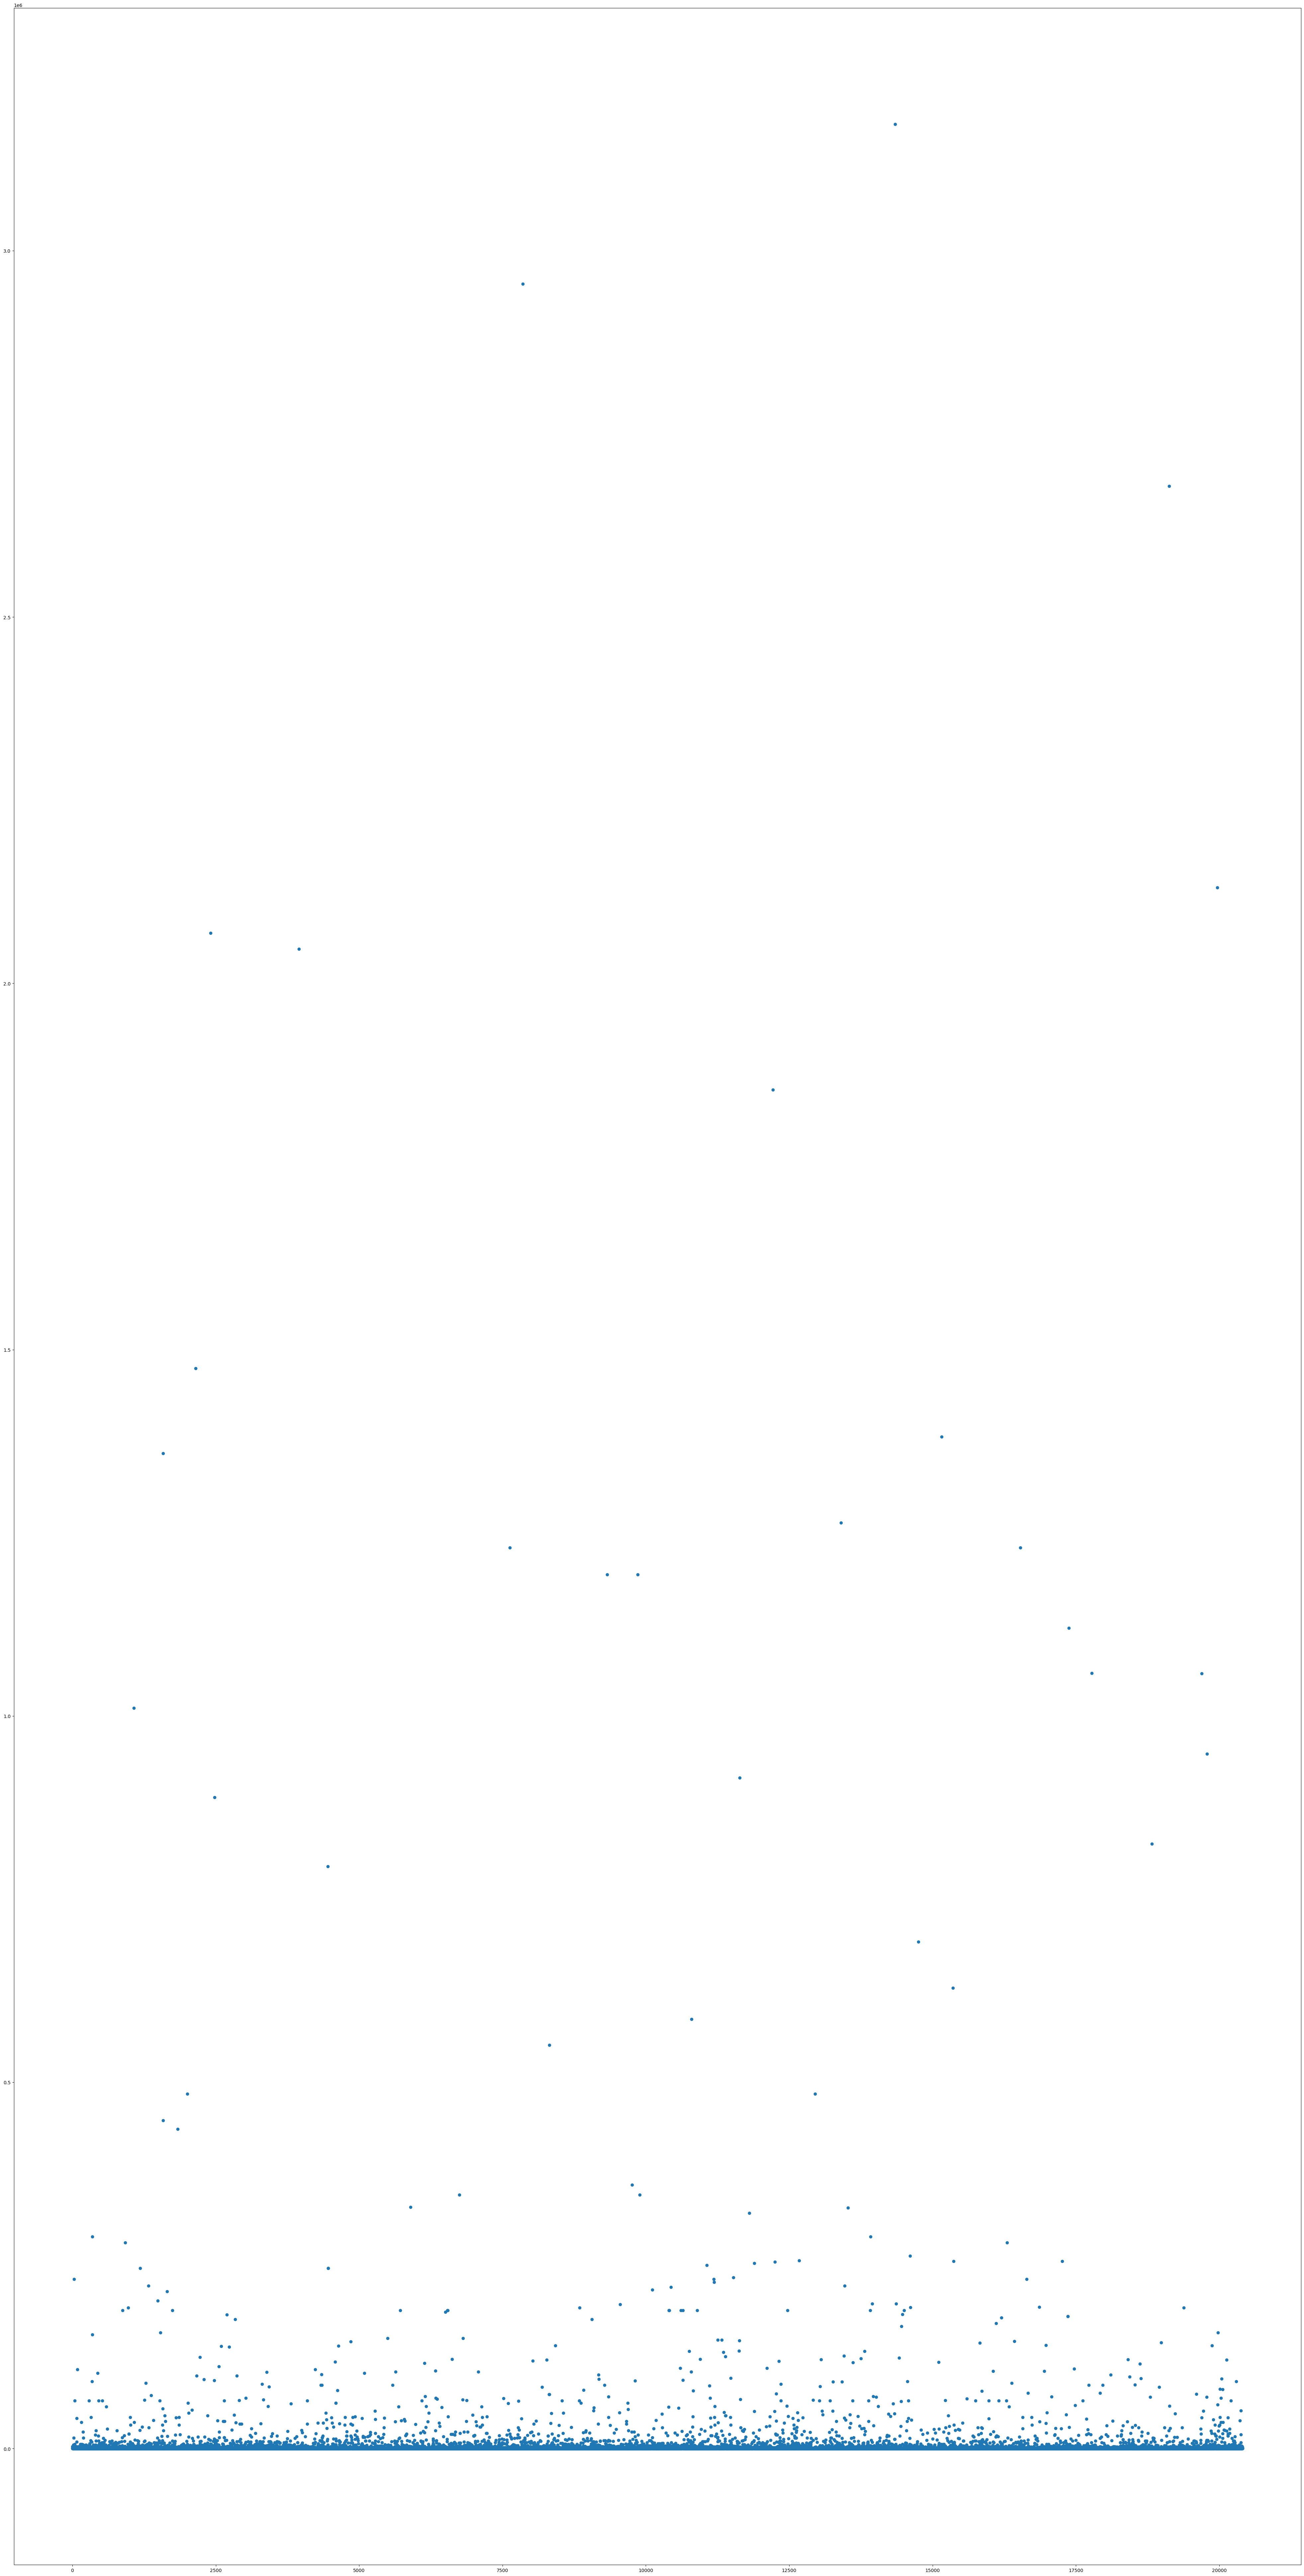

In [173]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(100)
plt.scatter(data.index,data['followers'])
plt.show()

In [142]:
data.iloc[8198]

following                                                     239
followers                                                     110
totaltweets                                                  1877
retweetcount                                                    2
created_at                              2022-07-13 09:37:58+00:00
clean_tweet     im so excited about the event in uyo for the f...
POS                                                      0.992538
NEU                                                      0.006388
NEG                                                      0.001073
Name: 8198, dtype: object

In [164]:
data['followers'].idxmax()

14347

In [165]:
data.iloc[14347]

following                             643
followers                         3172529
totaltweets                          6538
retweetcount                            2
created_at      2022-07-13 16:53:59+00:00
clean_tweet         bear flagdailybitcoin
POS                              0.067753
NEU                              0.797669
NEG                              0.134579
Name: 14347, dtype: object

In [170]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)
plt.hist(data['followers'].values,100000,density=True)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb3e2381dc0> (for post_execute):


KeyboardInterrupt: 

In [162]:
data['following'].max()

95212